# Distribution de clé quantique

## 1. Introduction

Lorsqu'Alice et Bob veulent communiquer un message secret (comme les coordonnées bancaires en ligne de Bob) sur un canal non sécurisé (comme Internet), il est essentiel de crypter le message. Étant donné que la cryptographie est un vaste domaine et que presque tout cela n'entre pas dans le cadre de ce manuel, nous devrons croire qu'Alice et Bob ayant une clé secrète que personne d'autre ne connaît est utile et leur permet de communiquer en utilisant la cryptographie à clé symétrique.

Si Alice et Bob veulent utiliser le canal de communication classique d'Eve pour partager leur clé, il est impossible de dire si Eve a fait une copie de cette clé pour elle-même - ils doivent faire entièrement confiance à Eve qu'elle n'écoute pas. Si, cependant, Eve fournit un canal de communication quantique, Alice et Bob n'ont plus du tout besoin de faire confiance à Eve - ils sauront si elle essaie de lire le message de Bob avant qu'il n'arrive à Alice.

Pour certains lecteurs, il peut être utile de donner une idée de la façon dont un canal quantique peut être physiquement mis en œuvre. Un exemple de canal classique pourrait être une ligne téléphonique ; nous envoyons des signaux électriques à travers la ligne qui représentent notre message (ou bits). Un exemple proposé de canal de communication quantique pourrait être une sorte de câble à fibre optique, à travers lequel nous pouvons envoyer des photons individuels (particules de lumière). Les photons ont une propriété appelée *polarisation,* et cette polarisation peut être l'un des deux états. Nous pouvons l'utiliser pour représenter un qubit.

## 2. Présentation du protocole

Le protocole utilise le fait que la mesure d'un qubit peut changer son état. Si Alice envoie un qubit à Bob et qu'un espion (Eve) essaie de le mesurer avant Bob, il est possible que la mesure d'Eve modifie l'état du qubit et que Bob ne reçoive pas l'état du qubit envoyé par Alice. 

In [1]:
from qiskit import QuantumCircuit, Aer, transpile
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np

Si Alice prépare un qubit dans l'état $|+\rangle$ ( `0` dans la base $X$), et Bob le mesure dans la base $X$, Bob est sûr de mesurer `0` :

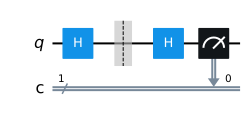

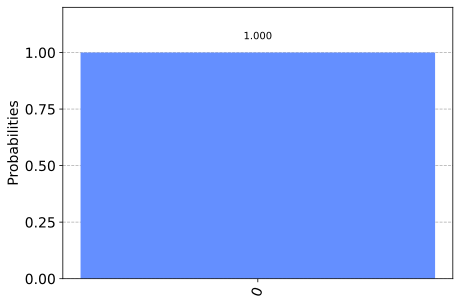

In [2]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

Mais si Eve essaie de mesurer ce qubit dans la base $Z$ avant qu'il n'atteigne Bob, elle changera l'état du qubit de $|+\rangle$ en $|0\rangle$ ou $|1\rangle$, et Bob n'est plus certain de mesurer `0` :

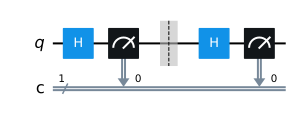

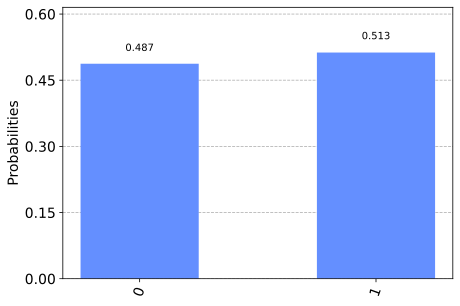

In [3]:
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(qc)
plot_histogram(job.result().get_counts())

Nous pouvons voir ici que Bob a maintenant 50 % de chances de mesurer `1` , et s'il le fait, lui et Alice sauront qu'il y a quelque chose qui ne va pas avec leur canal.

Le protocole de distribution de clé quantique implique de répéter ce processus suffisamment de fois pour qu'un indiscret ait une chance négligeable de s'en tirer avec cette interception. C'est à peu près comme suit:

**- Étape 1**

Alice choisit une chaîne de bits aléatoires, par exemple :

`1000101011010100`

Et un choix aléatoire de base pour chaque bit :

`ZZXZXXXZXZXXXXXX`

Alice garde ces deux informations privées pour elle.

**- Étape 2**

Alice encode ensuite chaque bit sur une chaîne de qubits en utilisant la base qu'elle a choisie; cela signifie que chaque qubit est dans l'un des états $|0\rangle$, $|1\rangle$, $|+\rangle$ ou $|-\rangle$, choisis au hasard. Dans ce cas, la chaîne de qubits ressemblerait à ceci :

$$ |1\rangle|0\rangle|+\rangle|0\rangle|-\rangle|+\rangle|-\rangle|0\rangle|-\rangle|1\rangle|+\rangle|-\rangle |+\rangle|-\rangle|+\rangle|+\rangle $$

C'est le message qu'elle envoie à Bob.

**- Étape 3**

Bob mesure ensuite chaque qubit au hasard, par exemple, il peut utiliser les bases :

`XZZZXZXZXZXZZZXZ`

Et Bob garde les résultats de mesure confidentiels.

**- Étape 4**

Bob et Alice partagent ensuite publiquement la base qu'ils ont utilisée pour chaque qubit. Si Bob a mesuré un qubit dans la même base qu'Alice l'a préparé, ils l'utilisent pour faire partie de leur clé secrète partagée, sinon ils rejettent les informations pour ce bit.

**- Étape 5**

Enfin, Bob et Alice partagent un échantillon aléatoire de leurs clés, et si les échantillons correspondent, ils peuvent être sûrs (avec une petite marge d'erreur) que leur transmission est réussie.


## 3. Exemple de Qiskit : sans interception

Voyons d'abord comment le protocole fonctionne lorsque personne n'écoute, puis nous pourrons voir comment Alice et Bob sont capables de détecter un indiscret. Comme toujours, commençons par importer tout ce dont nous avons besoin :

Pour générer des clés pseudo-aléatoires, nous utiliserons la fonction `randint` de numpy. Pour vous assurer que vous pouvez reproduire les résultats sur cette page, nous allons définir la graine sur 0 :

In [4]:
np.random.seed(seed=0)

Nous appellerons la longueur du message initial d'Alice `n` . Dans cet exemple, Alice enverra un message de 100 qubits :

In [5]:
n = 100

### 3.1 Étape 1 :

Alice génère son ensemble aléatoire de bits :

In [6]:
np.random.seed(seed=0)
n = 100
## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


Pour le moment, l'ensemble de bits ' `alice_bits` ' n'est connu que d'Alice. Nous garderons une trace des informations connues uniquement d'Alice, des informations connues uniquement de Bob et de ce qui a été envoyé sur le canal d'Eve dans un tableau comme celui-ci :

Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |

### 3.2 Étape 2 :

Alice choisit d'encoder chaque bit sur qubit dans la base $X$ ou $Z$ au hasard, et stocke le choix pour chaque qubit dans `alice_bases` . Dans ce cas, un `0` signifie "préparer dans la base $Z$", et un `1` signifie "préparer dans la base $X$":

In [7]:
np.random.seed(seed=0)
n = 100
## Step 1
#Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases)

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


Alice garde également cette connaissance privée :

Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |

La fonction `encode_message` ci-dessous crée une liste de `QuantumCircuit` s, chacun représentant un seul qubit dans le message d'Alice :

In [8]:
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message

In [9]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

Nous pouvons voir que le premier bit dans `alices_bits` est `0` , et la base dans laquelle elle l'encode est la base $X$ (représentée par `1` ) :

In [10]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 1


Et si nous visualisons le premier circuit dans `message` (représentant le premier qubit dans le message d'Alice), nous pouvons vérifier qu'Alice a préparé un qubit dans l'état $|+\rangle$ :

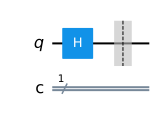

In [11]:
message[0].draw()

Comme autre exemple, nous pouvons voir que le quatrième bit dans `alice_bits` est `1` , et il est encodé dans la base $Z$, Alice prépare le qubit correspondant dans l'état $|1\rangle$ :

bit = 1
basis = 0


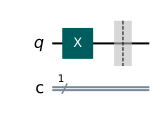

In [12]:
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw()

Ce message de qubits est ensuite envoyé à Bob via le canal quantique d'Eve :

Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message

### 3.3 Étape 3 :

Bob mesure ensuite chaque qubit dans la base $X$ ou $Z$ au hasard et stocke ces informations :

In [13]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


`bob_bases` stocke le choix de Bob pour quelle base il mesure chaque qubit.

Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message
 |  | bob_bases

Ci-dessous, la fonction `measure_message` applique la mesure correspondante et simule le résultat de la mesure de chaque qubit. Nous stockons les résultats de mesure dans `bob_results` .

In [14]:
def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        result = aer_sim.run(message[q], shots=1, memory=True).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [15]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

Nous pouvons voir que le circuit dans `message[0]` (représentant le 0ème qubit) a eu une mesure $X$ ajoutée par Bob :

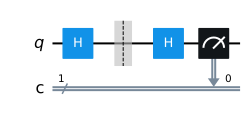

In [16]:
message[0].draw()

Puisque Bob a choisi par hasard de mesurer dans la même base qu'Alice a encodé le qubit, Bob est assuré d'obtenir le résultat `0` . Pour le 6e qubit (illustré ci-dessous), le choix aléatoire de mesure de Bob n'est pas le même que celui d'Alice, et le résultat de Bob n'a que 50 % de chances de correspondre à celui d'Alice. 

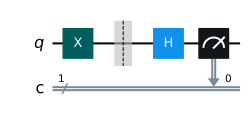

In [17]:
message[6].draw()

In [18]:
print(bob_results)

[0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0]


Bob garde ses résultats confidentiels.

Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message
 |  | bob_bases
 |  | bob_results

### 3.4 Étape 4 :

Après cela, Alice révèle (via le canal d'Eve) quels qubits ont été encodés dans quelle base :

Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases

Et Bob révèle sur quelle base il a mesuré chaque qubit :

Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |

Si Bob a mesuré un bit dans la même base qu'Alice l'a préparé, cela signifie que l'entrée dans `bob_results` correspondra à l'entrée correspondante dans `alice_bits` , et ils peuvent utiliser ce bit dans le cadre de leur clé. S'ils ont mesuré dans différentes bases, le résultat de Bob est aléatoire et ils rejettent tous les deux cette entrée. Voici une fonction `remove_garbage` qui fait cela pour nous :

In [19]:
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits

Alice et Bob rejettent tous les deux les bits inutiles et utilisent les bits restants pour former leurs clés secrètes :

In [20]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |
alice_key |  | 

In [21]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |
alice_key |  | bob_key

### 3.5 Étape 5 :

Enfin, Bob et Alice comparent une sélection aléatoire des bits de leurs clés pour s'assurer que le protocole a fonctionné correctement :

In [22]:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample

Alice et Bob les diffusent tous deux publiquement et les retirent de leurs clés car ils ne sont plus secrets :

In [23]:
np.random.seed(seed=0)
n = 100

## Step 1
# Alice generates bits
alice_bits = randint(2, size=n)

## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)

## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)

## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)

## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
alice_sample = [0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |
alice_key |  | bob_key
bob_sample | bob_sample | bob_sample
alice_sample | alice_sample | alice_sample

Si le protocole a fonctionné correctement sans interférence, leurs échantillons doivent correspondre :

In [24]:
bob_sample == alice_sample

True

Si leurs échantillons correspondent, cela signifie (avec une forte probabilité) `alice_key == bob_key` . Ils partagent désormais une clé secrète qu'ils peuvent utiliser pour chiffrer leurs messages !

Le savoir d'Alice | Sur le canal d'Eve | Les connaissances de Bob
:-: | :-: | :-:
alice_bits |  |
alice_bases |  |
un message | un message | un message
 |  | bob_bases
 |  | bob_results
 | alice_bases | alice_bases
bob_bases | bob_bases |
alice_key |  | bob_key
bob_sample | bob_sample | bob_sample
alice_sample | alice_sample | alice_sample
clé partagée |  | clé partagée

In [25]:
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
[1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0]
key length = 33


## 4. Exemple de Qiskit : *avec* interception

Voyons maintenant comment Alice et Bob peuvent dire si Eve a essayé d'écouter leur message quantique. Nous répétons les mêmes étapes que sans interférence, mais avant que Bob ne reçoive ses qubits, Eve va essayer d'en extraire des informations. Définissons une graine différente afin d'obtenir un ensemble spécifique de résultats "aléatoires" reproductibles :

In [26]:
np.random.seed(seed=3)

### 4.1 Étape 1 :

Alice génère son ensemble de bits aléatoires :

In [27]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]


### 4.2 Étape 2 :

Alice les encode dans les bases $Z$ et $X$ au hasard, et les envoie à Bob via le canal quantique d'Eve :

In [28]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


Dans ce cas, le premier qubit du message d'Alice est dans l'état $|+\rangle$ :

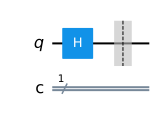

In [29]:
message[0].draw()

### Interception!

Oh non! Eve intercepte le message lorsqu'il passe par son canal. Elle essaie de mesurer les qubits dans une sélection aléatoire de bases, de la même manière que Bob le fera plus tard.

In [30]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0]


Nous pouvons voir le cas du qubit 0 ci-dessous ; Le choix aléatoire de la base d'Eve n'est pas le même que celui d'Alice, et cela changera l'état du qubit de $|+\rangle$, à un état aléatoire dans la base $Z$, avec une probabilité de 50 % de $|0\rangle$ ou $|1\rangle$ :

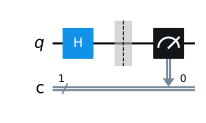

In [31]:
message[0].draw()

### 4.3 Étape 3 :

Eve transmet ensuite les qubits à Bob, qui les mesure au hasard. Dans ce cas, Bob a choisi (par hasard) de mesurer dans la même base qu'Alice a préparé le qubit. Sans interception, Bob serait assuré de mesurer `0` , mais parce qu'Eve a essayé de lire le message, il a maintenant 50 % de chances de mesurer `1` à la place.

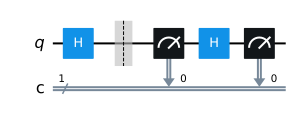

In [32]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
message[0].draw()

### 4.4 Étape 4 :

Bob et Alice révèlent leurs choix de base et rejettent les éléments inutiles :

In [33]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

### 4.5 Étape 5 :

Bob et Alice comparent la même sélection aléatoire de leurs clés pour voir si les qubits ont été interceptés :

In [34]:
np.random.seed(seed=3)
## Step 1
alice_bits = randint(2, size=n)
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
## Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [35]:
bob_sample == alice_sample

False

Oh non! La clé de Bob et la clé d'Alice ne correspondent pas. Nous savons que c'est parce qu'Eve a essayé de lire le message entre les étapes 2 et 3 et a changé les états des qubits. Pour autant qu'Alice et Bob le sachent, cela pourrait être dû au bruit dans le canal, mais dans tous les cas, ils doivent jeter tous leurs résultats et réessayer - la tentative d'interception d'Eve a échoué.

## 5. Analyse des risques

Pour ce type d'interception, dans laquelle Eve mesure tous les qubits, il y a une petite chance que les échantillons de Bob et d'Alice correspondent, et Alice envoie son message vulnérable via le canal d'Eve. Calculons cette chance et voyons à quel point la distribution de clé quantique est risquée.

- Pour qu'Alice et Bob utilisent le résultat d'un qubit, ils doivent tous les deux avoir choisi la même base. Si Eve choisit également cette base, elle réussira à intercepter ce bit sans introduire d'erreur. Il y a 50% de chances que cela se produise.
- Si Eve choisit la *mauvaise* base, c'est-à-dire une base différente d'Alice et de Bob, il y a encore 50 % de chances que Bob mesure la valeur qu'Alice essayait d'envoyer. Dans ce cas, l'interception passe également inaperçue.
- Mais si Eve choisit la *mauvaise* base, c'est-à-dire une base différente d'Alice et Bob, il y a 50% de chances que Bob ne mesure pas la valeur qu'Alice essayait d'envoyer, et *cela* introduira une erreur dans leurs clés.

![arbre de probabilité de risque](images/qkd_risk.svg)

Si Alice et Bob comparent 1 bit de leurs clés, la probabilité que les bits correspondent est de 0,75 $, et si c'est le cas, ils ne remarqueront pas l'interception d'Eve. S'ils mesurent 2 bits, il y a 0,75 $ ^ 2 = 0,5625 $ de chances que l'interception ne soit pas remarquée. Nous pouvons voir que la probabilité qu'Eve ne soit pas détectée peut être calculée à partir du nombre de bits ($x$) qu'Alice et Bob ont choisi de comparer :

$$ P(\text{non détecté}) = 0,75^x $$

Si nous décidons de comparer 15 bits comme nous l'avons fait ci-dessus, il y a 1,3 % de chances qu'Eve ne soit pas détectée. Si c'est trop risqué pour nous, nous pourrions comparer 50 bits à la place, et avoir 0,00006% de chance d'être espionné sans le savoir.

Vous pouvez réessayer le protocole en exécutant la cellule ci-dessous. Essayez de changer `sample_size` en quelque chose de faible et voyez à quel point il est facile pour Eve d'intercepter les clés d'Alice et de Bob.

In [36]:
n = 100
# Step 1
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
# Step 2
message = encode_message(alice_bits, alice_bases)
# Interception!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
# Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
# Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
# Step 5
sample_size = 15 # Change this to something lower and see if 
                 # Eve can intercept the message without Alice
                 # and Bob finding out
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

Eve's interference was detected.


In [37]:
import qiskit.tools.jupyter
%qiskit_version_table

/usr/local/anaconda3/envs/terra-unstable/lib/python3.9/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
